# Multi-agent supervisor

In this tutorial, you will build a [multi-agent supervisor](../../../concepts/multi_agent#supervisor) system.

**Supervisor** is an architecture where **specialized** agents are coordinated by a central **supervisor agent**. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

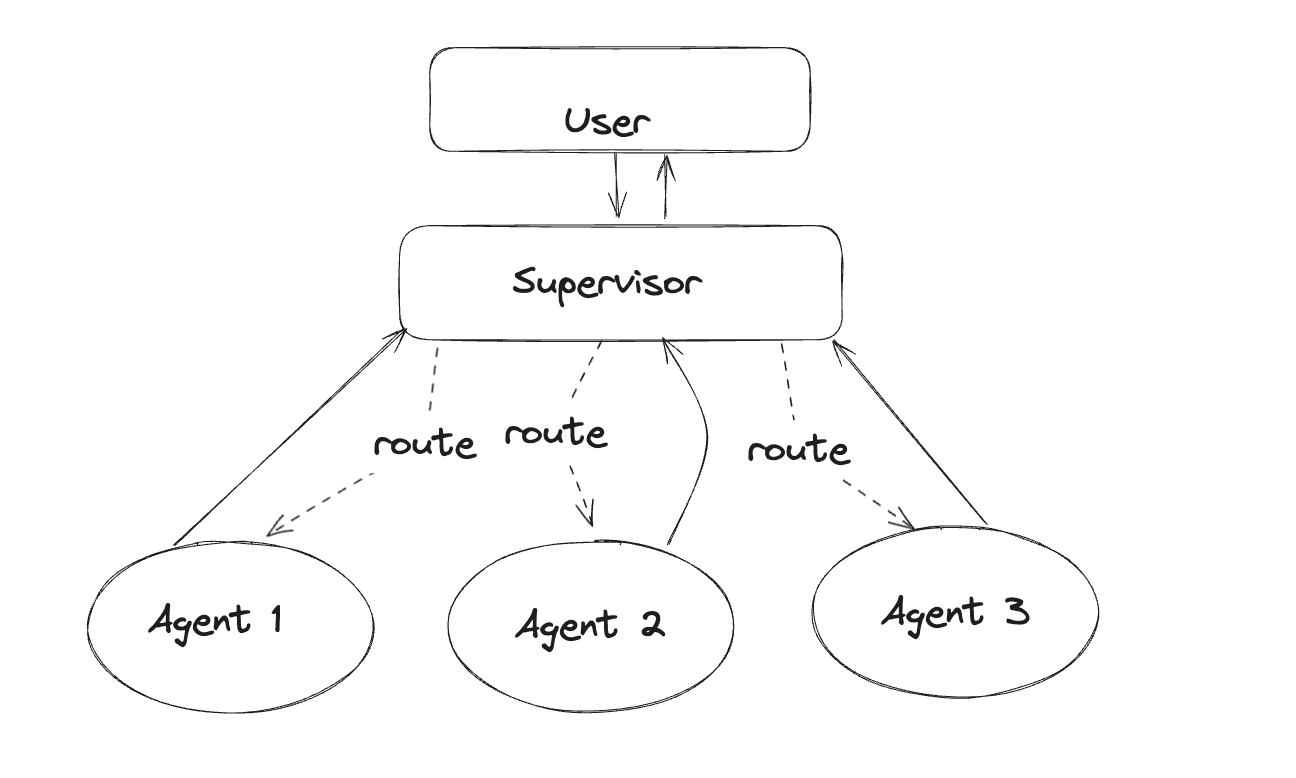

By the end of tutorial you will create an agent team with a supervisor and two agents — a research agent and a math expert.

## Setup

First, let's install required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph "langchain[anthropic]"

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create worker agents

First, let's create our specialized worker agents — `research_agent` and `math_agent`:

* Research agent will have access to a web search tool using [Tavily API](https://tavily.com/)
* Math agent will have access to simple math tools (`add`, `multiply`, `divide`)

For web search, we will use `TavilySearch` tool from `langchain-tavily`:

In [3]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City’s economy, reduce inequality, improve public safety, and build a stronger, healthier city that delivers for all New Yorkers. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. NYC is a trademark and service mark of the City of New York.


For math tools we will simply define [vanilla Python functions](../../../agents/tools#define-simple-tools) as tools:

In [4]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

To create individual worker agents, we will use LangGraph's prebuilt [agent](../../../agents/agents#basic-configuration).

In [5]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, do not do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

Let's [run our agents](../../../agents/run_agents) to verify that they behave as expected. Below we define a helper function to render the streamed agent outputs nicely:

In [6]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [7]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_y1iZxFKYrizdCv5YCrNeQq6d)
 Call ID: call_y1iZxFKYrizdCv5YCrNeQq6d
  Args:
    query: current mayor of New York City


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "List of mayors of New York City - Wikipedia", "url": "https://en.wikipedia.org/wiki/List_of_mayors_of_New_York_City", "content": "The mayor of New York City is the chief executive of the Government of New York City, as stipulated by New York City's charter.The current officeholder, the 110th in the sequence of regular mayors, is Eric Adams, a member of the Democratic Party.. During the Dutch colonial period from 1624 to 1664, New Amsterdam was governed by the Di

In [8]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_I0yaRqnniuJMP6pAJkmY6vK0)
 Call ID: call_I0yaRqnniuJMP6pAJkmY6vK0
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_xvNtScjAX8AgtvJkp39xN28i)
 Call ID: call_xvNtScjAX8AgtvJkp39xN28i
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




## Set up agent communication

Now that we've created and tested individual agents, we need to define a way for the supervisor agent to communicate with the worker agents. A common pattern to implement this in multi-agent architectures is **handoffs**, where one agent *hands off* control to another. Handoffs allow you to specify:

- **destination**: target agent to navigate to
- **payload**: information to pass to that agent

We will implement handoffs via **handoff tools** and give these tools to the supervisor agent: when the supervisor calls these tools, it will hand off control to a worker agent, passing the full message history to that agent.

In [9]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"assign_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,
            # highlight-next-line
            update={"messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

## Create supervisor

Finally, let's create the supervisor agent with the handoff tools we just defined. We will use the prebuilt [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent]:

In [10]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

Putting this all together, let's create a graph for our overall multi-agent system. We will add the supervisor and the individual agents as [subgraph](../../../concepts/low_level#subgraphs) nodes.

In [11]:
# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent"))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

Notice that we've added explicit [edges](../../../concepts/low_level#edges) from worker agents back to the supervisor — this means that they are guaranteed to return control back to the supervisor. If you want the agents to respond directly to the user (i.e., turn the system into a router, you can remove these edges).

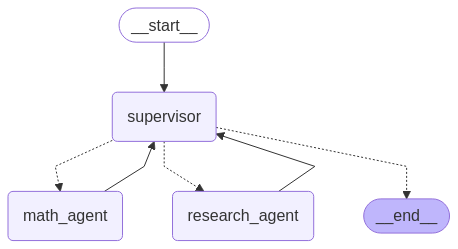

In [12]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

## Run the team

With the multi-agent graph created, let's now run it with a query that requires both agents:

* research agent will look up the necessary GDP information
* math agent will perform division to find the percentage of NY state GDP, as requested

In [13]:
for chunk in supervisor.stream(
    {
        "messages": [
            {"role": "user", "content": "what % of US GDP was New York state in 2024?"}
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: assign_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

- New York State GDP in 2024: $2.284 trillion ([source](https://en.wikipedia.org/wiki/Economy_of_New_York_(state)))
- US GDP in 2024: $29.017 trillion ([source](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP))

New York's percentage of the US GDP in 2024: approximately 7.87%.


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

In 2024, New York state's GDP was $2.284 trillion and the total US GDP was $29.017 trillion. This means New York represented about 7.87% of the US GDP in 2024.




Let's examine the full resulting message history:

In [14]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

what % of US GDP was New York state in 2024?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  assign_to_research_agent (call_qvEVL32HAUcUB0jNWzfEuD6v)
 Call ID: call_qvEVL32HAUcUB0jNWzfEuD6v
  Args:
================================= Tool Message =================================
Name: assign_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_d9LKBp1vBcHm6B3hgzbLpSgm)
 Call ID: call_d9LKBp1vBcHm6B3hgzbLpSgm
  Args:
    query: New York state share of US GDP in 2024
    search_depth: advanced
  tavily_search (call_S9BPobLqLhPi1KSmMBJaTuXK)
 Call ID: call_S9BPobLqLhPi1KSmMBJaTuXK
  Args:
    query: US GDP 2024
    search_depth: basic
  tavily_search (call_jagSWQFHWn8jEi7QggpA9rOQ)
 Call ID: call_jagSWQF

!!! Important

    You can see that the supervisor system appends **all** of the individual agent messages (i.e., their internal tool-calling loop) to the full message history. This means that on every supervisor turn, supervisor agent sees this full history. If you want more control over:

    * **inputs are passed to agents**: you can use LangGraph [`Send()`][langgraph.types.Send] primitive to directly send data to the worker agents during the handoff. See the [task delegation](#create-delegation-tasks) example below
    * **how agent outputs are added**: you can control how much of the agent's internal message history is added to the overall supervisor message history by wrapping the agent in a separate node function. See the example of [returning final agent response](#return-final-agent-response) below.

## Return final agent response

The multi-agent system we defined above appends all of the individual messages to the full supervisor message history. If you want to **only append the final response** from each agent, you can manually call the agents inside node functions and filter their outputs to return a subset of messages. Let's change our example to return only the last message:

In [20]:
def call_research_agent(state):
    # return agent's final response,
    # excluding inner monologue
    response = research_agent.invoke(state)
    # highlight-next-line
    return {"messages": response["messages"][-1]}


def call_math_agent(state):
    response = math_agent.invoke(state)
    return {"messages": response["messages"][-1]}


supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent"))
    .add_node("research_agent", call_research_agent)
    .add_node("math_agent", call_math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

Let's now re-run the same example and examine the resulting message history:

In [23]:
supervisor_final_agent_responses = supervisor.invoke(
    {
        "messages": [
            {"role": "user", "content": "what % of US GDP was New York state in 2024?"}
        ]
    }
)

In [24]:
for message in supervisor_final_agent_responses["messages"]:
    message.pretty_print()

================================ Human Message =================================

what % of US GDP was New York state in 2024?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  assign_to_research_agent (call_BpaNCObfRfr9duFu8rEl0myK)
 Call ID: call_BpaNCObfRfr9duFu8rEl0myK
  Args:
================================= Tool Message =================================
Name: assign_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent

- New York's GDP in 2024 was $2.284 trillion.[1][2]
- The US GDP in 2024 was $29.017 trillion.[2]

Sources:
1. https://en.wikipedia.org/wiki/Economy_of_New_York_(state)
2. https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  assign_to_math_agent (call_vlKYAbvNbQ7e0

As expected, we now only append the final AI message from each agent.

## Create delegation tasks

So far the individual agents relied on **interpreting full message history** to determine their tasks. An alternative approach is to ask the supervisor to **formulate a task explicitly**. We can do so by adding a `task_description` parameter to the `handoff_tool` function.

In [18]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"assign_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    # here we continue using `call_<agent>` node functions
    # that return the last message, but you can adjust this as needed
    .add_node("research_agent", call_research_agent)
    .add_node("math_agent", call_math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

!!! note

    We're using [`Send()`][langgraph.types.Send] primitive in the `handoff_tool`. This means that instead of receiving the full `supervisor` graph state as input, each worker agent only sees the contents of the `Send` payload. In this example, we're sending the task description as a single "human" message.

Let's now running it with the same input query:

In [19]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {"role": "user", "content": "what % of US GDP was New York state in 2024?"}
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  assign_to_research_agent (call_8M3SNA1mzNAab0K60SGeNIXL)
	 Call ID: call_8M3SNA1mzNAab0K60SGeNIXL
	  Args:
	    task_description: Find the most current data (preferably 2024 or latest available) for the GDP of New York State and the total US GDP. Verify their compatibility in terms of reporting year. Then, report both numbers for further calculations.


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_mOcOpxaRavcr9VgC7glNkrGZ)
	 Call ID: call_mOcOpxaRavcr9VgC7glNkrGZ
	  Args:
	    query: latest GDP of New York State
	    search_depth: advanced
	  tavily_search (call_Y6ZW3d3XMqsQav62HoI0ok09)
	 Call ID: call_Y6ZW3d3XMqsQav62HoI0ok09
	  Args:
	    query: late